# Politics

- Data Cleaning
- Data Visualisation
- Data Analysis

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [91]:
# Reading the data from politics revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/politics_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/politics.csv')

In [92]:
print("Number of Revisions in Politics Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Politics Dataset")
print(items.shape)

Number of Revisions in Politics Dataset
(3915164, 12)
Number of Wikidata Items in Politics Dataset
(414463, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [93]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [94]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [95]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [96]:
rev.shape

(3915164, 9)

In [97]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [98]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [99]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [100]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [101]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [102]:
editscount = rev['qid'].value_counts()

In [103]:
editscount.describe()

count    413848.000000
mean          9.417475
std          17.753846
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max        1431.000000
Name: qid, dtype: float64

Rationale for Removing edits <= 5

- Research
- Range of edits is very large
- Median value that is the 50th percentile is 3 edits that is more than half the dataset has items that would not be very interesting to the research as we are interested in highly edited items
- Items in the 75th percentile have an editcount of 8 showing that only a small percentage of items - slightly greater than 25% of the items are those that can be deemed interesting
- Also important to note that given these values, the data could also contain a reasonable number of outliers - items which are highly edited but do not add value to the research - for example they do not contain reverts or they are sandbox items

In [104]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [106]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
100579
Items with No of Edits = 2
75742
Items with No of Edits = 3
40352
Items with No of Edits = 4
32317
Items with No of Edits = 5
22804
Items with No of Edits <= 5
271794


In [107]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [108]:
df_editscount.shape

(142054, 2)

In [109]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [111]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [112]:
# To query info based on datetime remember to input dates in complete formatting
# rev[rev['timestamp'] >= '2016-10-01 00:00:00']

Imp to parse timestamps as you would potentially be interested in looking at the time difference between edits in the future, difference between datetime objects can be found using timedelta from datetime.

In [113]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

# Descriptive Statistics

In [124]:
rev['editscount'].describe().astype(int)

count    3280996
mean          50
std           57
min            6
25%           16
50%           63
75%           65
max         1431
Name: editscount, dtype: int32

In [126]:
rev['type'].describe()

count     3280996
unique         10
top           add
freq      2606668
Name: type, dtype: object

In [114]:
# TODO: Calculate number of items in different ranges and plot in bar chart

In [132]:
politics_items = rev['qid'].value_counts()

In [137]:
# converting a series to a dataframe
p_items = pd.DataFrame({'type':politics_items.index, 'count':politics_items.values})

In [156]:
# Items between the median and 75th percentile
p_items[(p_items['count'] >= 63) & (p_items['count'] <= 65)]

,type,count
9435,Q1105654,65
9436,Q258757,65
9437,Q148855,65
9438,Q228794,65
9439,Q2260522,65
...,...,...
23984,Q21865,63
23985,Q124145,63
23986,Q763491,63
23987,Q1143819,63


# Statistics for Proxies

In [198]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [199]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      2606668
create    381977
update    195971
remove     64258
set        28667
undo        1086
revert      1060
merge        851
restore      434
protect       24


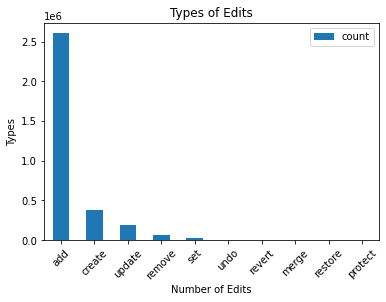

In [200]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

According to the bar plot the proxy with the highest occurrence is add followed by create, update, remove, set and those with no types specified (those without any comments). 

This was expected behaviour as this infers that editors are adding a lot of information to wikidata over a period of time. As we are exploring controversies in wikidata, the remaining edits namely - reverts, undos, removes, merges, restores and protect will be more useful thus we will visualise those.

In [201]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

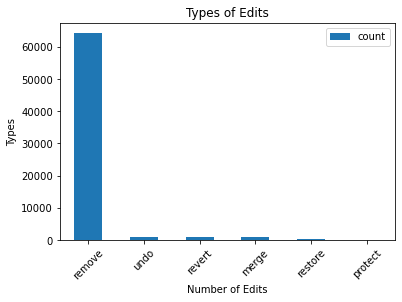

In [202]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Remove is very high as compared to the others to better understand them, let's plot these reverts itself [Can remove later]

In [204]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      1086
revert    1060
merge      851
restore    434
protect     24


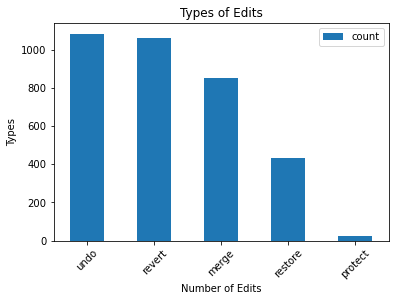

In [205]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Interesting to observe that the number of undos is greater that reverts. What could be the reason for this? What could be the potential impact? Could we consider undos as important as reverts? Undoing an edit, reverting to a previous edit. What value do they hold?

# Statistics for No of Edits

In [ ]:
# # Plotting No of Edits for the Items in the dataset 
# # Scatter Plot

# plt.scatter(politics_items.index, politics_items.values)

# plt.title("No of Edits vs No of Items")
# plt.xlabel("Number of Items")
# plt.ylabel("No of Edits")

# plt.show()

In [ ]:
no_of_edits = politics_items.to_numpy()

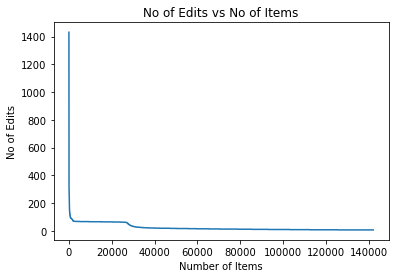

In [213]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Top 25% of the Dataset

As we want to get a closer look at the highly edited items, we are using the statistics obtained from the main dataset to look at the top 25% of items which had no of edits > 65

In [207]:
# Items that fall in the top 25% of the dataset
top_25_percent = p_items[p_items['count'] > 65]

In [208]:
top_25_percent.describe()

,count
count,9435.000000
mean,76.707684
std,39.381776
min,66.000000
25%,66.000000
50%,67.000000
75%,69.000000
max,1431.000000


In [ ]:
# No of items 
# between 66 - 100
# between 100 - 200
# between 200 - 300
# between 300 - 400
# between 500 - 600
# between 600 - 700
# between 700 - 800
# between 900 - 1000

In [ ]:
# Wordcloud for items

In [ ]:
# Remove sandbox

In [ ]:
# Sparql Query to get labels

In [115]:
rev.groupby("qid", sort=False)["type"].apply(lambda ser: ser.str.contains("revert").sum()).nlargest(10)

qid
Q4115189    19
Q517        15
Q6294       12
Q52         11
Q23         10
Q15975       9
Q182276      8
Q296741      8
Q29          7
Q77          7
Name: type, dtype: int64

In [116]:
reverts = rev["type"].str.contains("revert")

In [117]:
(reverts.groupby(rev["qid"], sort=False).sum().nlargest(50).astype(np.uintc))

qid
Q4115189    19
Q517        15
Q6294       12
Q52         11
Q23         10
Q15975       9
Q182276      8
Q296741      8
Q29          7
Q77          7
Q96          7
Q801         7
Q1124        7
Q9061        7
Q320         6
Q1001        6
Q5809        6
Q39444       6
Q44197       6
Q298         5
Q1048        5
Q1067        5
Q1399        5
Q2685        5
Q8768        5
Q11256       5
Q22686       5
Q33760       5
Q21          4
Q90          4
Q306         4
Q419         4
Q717         4
Q2807        4
Q9353        4
Q10261       4
Q29179       4
Q57311       4
Q138198      4
Q483654      4
Q200180      4
Q206855      4
Q216766      4
Q377623      4
Q736924      4
Q399         3
Q414         3
Q739         3
Q1486        3
Q2054        3
Name: type, dtype: uint32